In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dtype

In [13]:
dataset = AdSBHDataset(N=50, threshold=0.0)
# Remove negative data for testing purposes
dataset.L = dataset.L[dataset.labels<0.5]
dataset.V = dataset.V[dataset.labels<0.5]

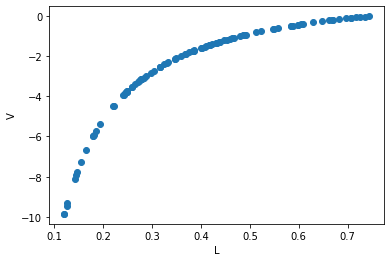

In [14]:
plt.scatter(dataset.L.numpy(), dataset.V.numpy())
plt.xlabel('L')
plt.ylabel('V');

## Consistency check
Learnable parameters set to zero (standard BH).

Text(0, 0.5, '$(V(data)-V(model))/V(data)$')

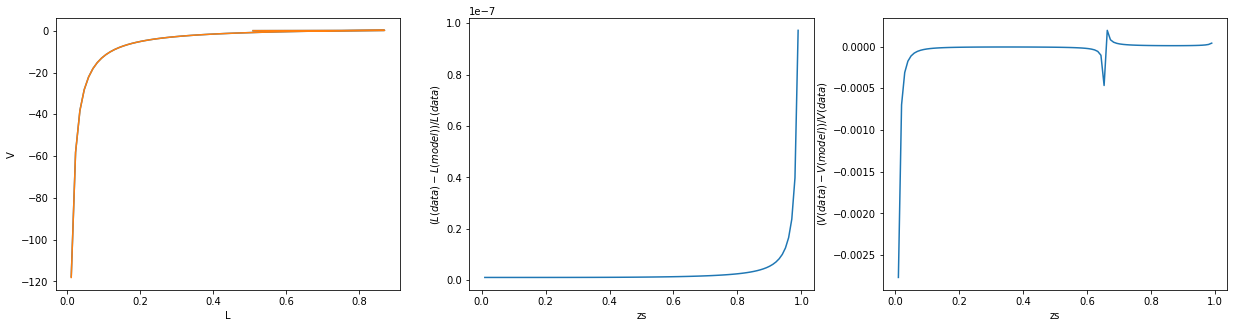

In [15]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
zs = np.linspace(0.01, 0.99, 100)
ps = np.sqrt(1-zs**4)/zs**2
d_L = np.array([dataset.integrate_L(z) for z in zs])
d_V = np.array([dataset.integrate_V(z) for z in zs])
m_L = np.array([model.integrate_L(z).item() for z in zs])
m_V = np.array([model.integrate_V(z).item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$')

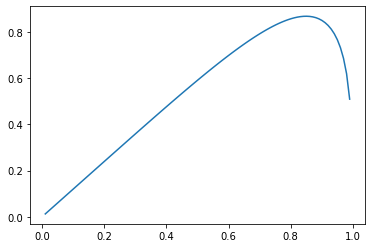

In [16]:
plt.plot(zs, m_L)

In [17]:
model.get_Lmax()

tensor(0.7541, dtype=torch.float64, grad_fn=<MulBackward0>)

Agreement between dataset and model is reasonable with zero parameters.

Let's check that $a=b=0$ is a local minimum of the loss function

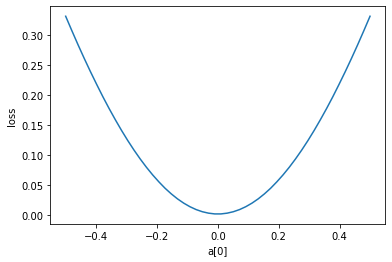

In [5]:
A = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    loss = F.l1_loss(model(dataset.L), dataset.V)
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with these results.

/home/arttu/venv/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


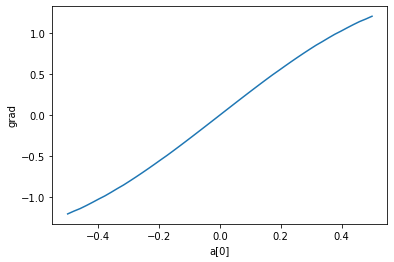

In [6]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.zero_grad()
    loss = F.l1_loss(model(dataset.L), dataset.V)
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

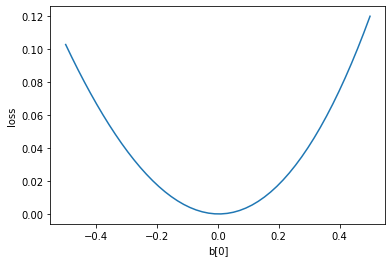

In [7]:
B = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dtype))
    loss = F.mse_loss(model(dataset.L), dataset.V)
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

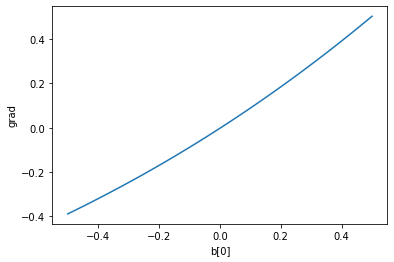

In [8]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dtype))
    model.zero_grad()
    loss = F.mse_loss(model(dataset.L), dataset.V)
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

In [9]:
model = AdSBHNet(N=1)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
#optimizer = torch.optim.RMSprop(model.parameters())
epochs = 200
a_vals, b_vals = [], []

try:
    for epoch in range(epochs):
        for L, V, Y in loader:
            optimizer.zero_grad()
            V_pred = model(L)
            loss = F.l1_loss(V_pred, V)
            loss.backward()
            a_vals.append(model.a.detach().numpy().copy())
            b_vals.append(model.b.detach().numpy().copy())
            optimizer.step()
        print(f'epoch={epoch:2d}, loss={loss.item():0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

epoch= 0, loss=0.025989
epoch= 1, loss=0.012041
epoch= 2, loss=0.012779
epoch= 3, loss=0.006203
epoch= 4, loss=0.007586
epoch= 5, loss=0.009016
epoch= 6, loss=0.010041
epoch= 7, loss=0.011200
epoch= 8, loss=0.005009
epoch= 9, loss=0.010815
epoch=10, loss=0.011619
epoch=11, loss=0.012510
epoch=12, loss=0.013321
epoch=13, loss=0.014131
epoch=14, loss=0.006888
epoch=15, loss=0.008183
epoch=16, loss=0.009477
epoch=17, loss=0.010761
epoch=18, loss=0.004770
epoch=19, loss=0.005186
epoch=20, loss=0.005605
epoch=21, loss=0.006394
epoch=22, loss=0.007189
epoch=23, loss=0.008002
epoch=24, loss=0.008761
epoch=25, loss=0.009550
epoch=26, loss=0.010326
epoch=27, loss=0.011095
epoch=28, loss=0.011859
epoch=29, loss=0.012645
epoch=30, loss=0.013380
epoch=31, loss=0.011166
epoch=32, loss=0.011946
epoch=33, loss=0.012713
epoch=34, loss=0.013457
epoch=35, loss=0.008522
epoch=36, loss=0.009306
epoch=37, loss=0.010051
epoch=38, loss=0.010831
epoch=39, loss=0.011609
epoch=40, loss=0.012367
epoch=41, loss=0

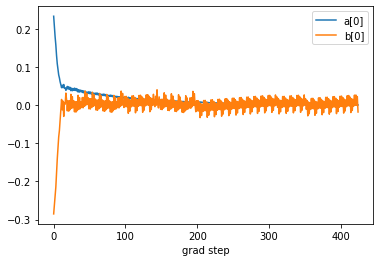

In [10]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend()

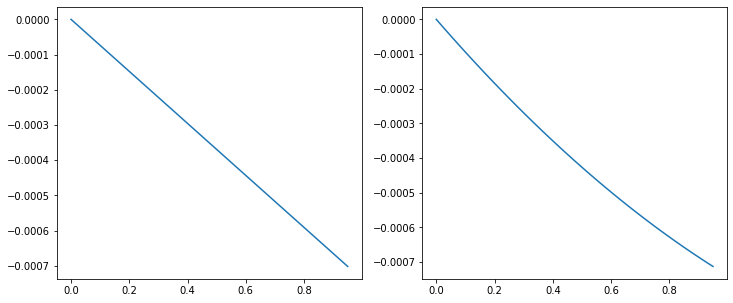

In [43]:
z = np.linspace(0, 0.95, 50)
fz = model.eval_f(z).detach().numpy()
fz0 = 1-z**4
gz = model.eval_g(z).detach().numpy()
gz0 = 1/(1-z**4)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(z, (fz-fz0)/fz0)
axs[1].plot(z, (gz-gz0)/gz0)

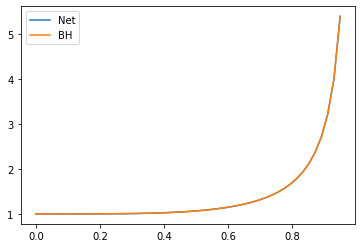

In [44]:
plt.plot(z, gz, label='Net')
plt.plot(z, gz0, label='BH')
plt.legend()

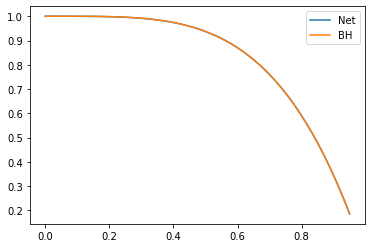

In [45]:
plt.plot(z, fz, label='Net')
plt.plot(z, fz0, label='BH')
plt.legend()

$$
\frac{1}{z^2} \left( -f(z) dt^2 + g(z) dz^2 + dx^2 + dy^2 \right)
$$

$$
f(z) = 1-z^4  \\
g(z) = 1/(1-z^4)
$$

$$
f(z) = (1-z^4)/e^{a(z)} \\
a(z) = \int_0^z (a_1 x + a_2 x^2 + \ldots )^2 dx
$$

$ f(z)/z^4 $

$$
g(z) = e^{b(z)}/(1-z^4) \\
b(z) = b_1 z + b_2 z^2 + \ldots + (\sum_i b_i + a(1)) z^{N+1}
$$